In [1]:
import os
#%pip uninstall -y numpy
#%pip install -U numpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats# Set the directory path where the CSV files are located
dir_path = "Preprocessed"
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Lambda
from sklearn.preprocessing import MinMaxScaler

### Load all the individual HUPA00xx.csv into df1, df2, etc.

In [2]:
# Create an empty list to store the dataframes
dfs = []

# Iterate over the files in the directory
for i in range(1, 26):
    # Construct the file name with zero-padding
    file_name = f"HUPA{str(i).zfill(4)}P.csv"
    
    # Join the directory path and file name
    file_path = os.path.join(dir_path, file_name)
    
    # Load the CSV file into a dataframe
    df = pd.read_csv(file_path, sep=";")
    
    # Append the dataframe to the list
    dfs.append(df)

# Assign the dataframes to individual variables
for i, df in enumerate(dfs, start=1):
    globals()[f"df{i}"] = df

In [3]:
df1

,time,glucose,calories,heart_rate,steps,basal_rate,bolus_volume_delivered,carb_input
0,2018-06-13T18:40:00,332.000000,6.3595,82.322835,34.0,0.091667,0.0,0.0
1,2018-06-13T18:45:00,326.000000,7.7280,83.740157,0.0,0.091667,0.0,0.0
2,2018-06-13T18:50:00,330.000000,4.7495,80.525180,0.0,0.091667,0.0,0.0
3,2018-06-13T18:55:00,324.000000,6.3595,89.129032,20.0,0.091667,0.0,0.0
4,2018-06-13T19:00:00,306.000000,5.1520,92.495652,0.0,0.075000,0.0,0.0
...,...,...,...,...,...,...,...,...
4091,2018-06-27T23:35:00,323.666667,5.2325,88.051724,0.0,0.058333,1.0,0.0
4092,2018-06-27T23:40:00,325.333333,4.1055,77.680672,0.0,0.058333,0.0,0.0
4093,2018-06-27T23:45:00,327.000000,4.0250,79.358974,0.0,0.058333,0.0,0.0
4094,2018-06-27T23:50:00,326.000000,4.1055,82.058333,0.0,0.058333,0.0,0.0


### Create function to create sequences of data for LSTM and preprocessing layer for physiological interpretation with concatenation

In [4]:
def create_sequences(df, target_column, window_size=30):
    """
    Create sequences of data from the dataframe for LSTM input.
    Args:
        df: DataFrame containing glucose, insulin, and carbohydrate data.
        target_column: Column name of the target variable (glucose levels).
        window_size: The number of timesteps in each input sequence.
    Returns:
        X: Input sequences (glucose, insulin, carbohydrate).
        y: Target output (future glucose levels).
    """
    X_cgm = []
    X_insulin = []
    X_cho = []
    y = []
    
    for i in range(len(df) - window_size):
        # Collect sequences of glucose, insulin, and carbohydrate inputs
        X_cgm.append(df["glucose"].values[i:i+window_size])
        X_insulin.append(df["bolus_volume_delivered"].values[i:i+window_size])
        X_cho.append(df["carb_input"].values[i:i+window_size])
        # Target is the glucose level at the next timestep
        y.append(df[target_column].values[i+window_size])
    
    return np.array(X_cgm), np.array(X_insulin), np.array(X_cho), np.array(y)

def physiological_preprocessing(inputs):
    """
    Apply preprocessing to inputs to enforce the physiological relationships:
    - Insulin reduces glucose (negative effect)
    - Carbohydrates increase glucose (positive effect)
    """
    cgm, insulin, cho = inputs
    # Apply transformations to enforce physiological interpretation
    insulin_processed = -1 * insulin  # Insulin decreases glucose
    cho_processed = cho               # Carbohydrates increase glucose
    cgm_processed = cgm               # Glucose values are passed through unchanged

    # Concatenate the processed inputs along the last axis (features axis)
    return tf.concat([cgm_processed, insulin_processed, cho_processed], axis=-1)

### Build the physiological LSTM model

In [5]:
def build_physiological_lstm(input_shape, lstm_units=64):
    """
    Builds the physiological LSTM model with a preprocessing layer.
    Args:
        input_shape: tuple, shape of the input data (timesteps, features).
        lstm_units: int, number of units in the LSTM layer.
    Returns:
        model: a compiled Keras model.
    """
    # Inputs for glucose (CGM), insulin, and carbohydrates (CHO)
    cgm_input = Input(shape=(input_shape[0], 1), name="CGM_Input")
    insulin_input = Input(shape=(input_shape[0], 1), name="Insulin_Input")
    cho_input = Input(shape=(input_shape[0], 1), name="CHO_Input")

    # Apply physiological preprocessing with explicit output shape
    processed_inputs = Lambda(physiological_preprocessing, output_shape=(input_shape[0], 3))([cgm_input, insulin_input, cho_input])

    # LSTM layer for time dependencies
    lstm_layer = LSTM(units=lstm_units, return_sequences=False, name="LSTM_Layer")(processed_inputs)

    # Dense output layer to predict future glucose levels
    output = Dense(1, activation='linear', name="Output_Layer")(lstm_layer)

    # Define the model
    model = Model(inputs=[cgm_input, insulin_input, cho_input], outputs=output)

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    return model

### Normalize the data

In [6]:
scaler = MinMaxScaler()
df1[["glucose", "bolus_volume_delivered", "carb_input"]] = scaler.fit_transform(df1[["glucose", "bolus_volume_delivered", "carb_input"]])

### Setg hyperparameters. Define feature subsets.  Do train-test split (80% train)

In [7]:
# Hyperparameters
window_size = 30  # Number of timesteps in each sequence
train_size_ratio = 0.8  # 80% train, 20% test

# Create sequences for the LSTM model from the entire dataset
X_cgm, X_insulin, X_cho, y_glucose = create_sequences(df1, target_column="glucose", window_size=window_size)

# Reshape the inputs to the format required by Keras (samples, timesteps, features)
X_cgm = X_cgm.reshape(X_cgm.shape[0], X_cgm.shape[1], 1)
X_insulin = X_insulin.reshape(X_insulin.shape[0], X_insulin.shape[1], 1)
X_cho = X_cho.reshape(X_cho.shape[0], X_cho.shape[1], 1)

# Calculate the training set size based on the ratio
train_size = int(len(y_glucose) * train_size_ratio)

# Sequentially split the data into training and test sets
X_cgm_train, X_cgm_test = X_cgm[:train_size], X_cgm[train_size:]
X_insulin_train, X_insulin_test = X_insulin[:train_size], X_insulin[train_size:]
X_cho_train, X_cho_test = X_cho[:train_size], X_cho[train_size:]

y_train, y_test = y_glucose[:train_size], y_glucose[train_size:]

### Build the model

In [8]:
input_shape = (window_size, 1)  # 30 timesteps and 1 feature per input (glucose, insulin, or carbs)
model = build_physiological_lstm(input_shape=input_shape)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ CGM_Input           │ (None, 30, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Insulin_Input       │ (None, 30, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CHO_Input           │ (None, 30, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 30, 3)     │          0 │ CGM_Input[0][0],  │
│                     │                   │            │ Insulin_Input[0]… │
│                     │                   │            │ CHO_Input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LSTM_Layer (LSTM)   │ (None, 64)        │     17,408 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output_Layer        │ (None, 1)         │         65 │ LSTM_Layer[0][0]  │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 17,473 (68.25 KB)

 Trainable params: 17,473 (68.25 KB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [9]:
# Train the model
model.fit([X_cgm, X_insulin, X_cho], y_glucose, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['CGM_Input', 'Insulin_Input', 'CHO_Input']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0352 - mae: 0.1306 - val_loss: 0.0042 - val_mae: 0.0467
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0043 - mae: 0.0479 - val_loss: 0.0029 - val_mae: 0.0381
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0038 - mae: 0.0445 - val_loss: 0.0025 - val_mae: 0.0347
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032 - mae: 0.0406 - val_loss: 0.0022 - val_mae: 0.0328
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - mae: 0.0401 - val_loss: 0.0019 - val_mae: 0.0297
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0400 - val_loss: 0.0017 - val_mae: 0.0289
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0386 - val_loss: 0.0017 - val_mae: 0.0287
Epoch 8/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - mae: 0.0386 - val_loss: 0.0017 - val_mae: 0.0282
Epoch 9/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0027 

### Make predictions and plot over actual data

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


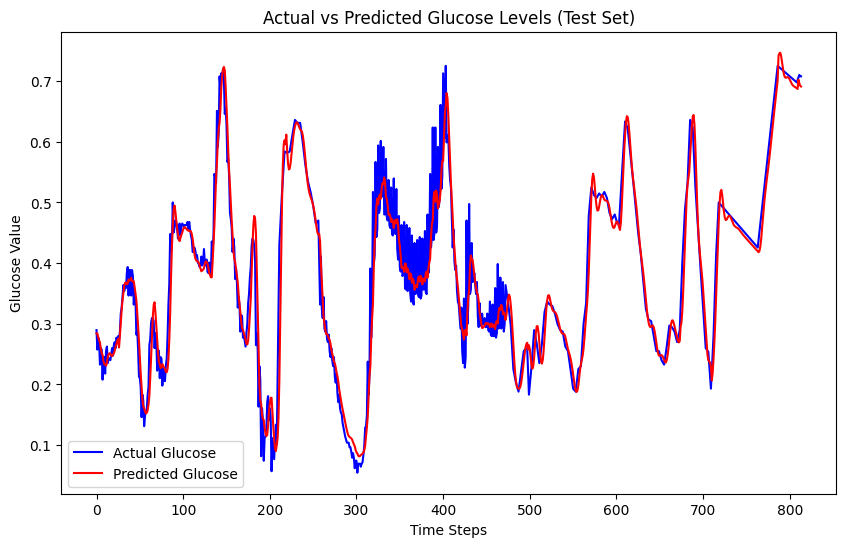

In [10]:
# Generate predictions on the validation data
y_pred_test = model.predict([X_cgm_test, X_insulin_test, X_cho_test])

# Plot the actual vs predicted glucose values
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Glucose', color='b')
plt.plot(y_pred_test, label='Predicted Glucose', color='r')
plt.title('Actual vs Predicted Glucose Levels (Test Set)')
plt.xlabel('Time Steps')
plt.ylabel('Glucose Value')
plt.legend()
plt.show()

In [11]:
#%pip install shap
import shap

### Concatenate the 3 features to feed into SHAP. Plot SHAP summary beeswarm plot.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
6875/6875 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6875/6875 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
6875/6875 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6875/6875 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
6875/6875 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
6875/6875 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6875/6875 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
6875/6875 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6875/6875 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
6875/6875 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6875/6875 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
6875/6875 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

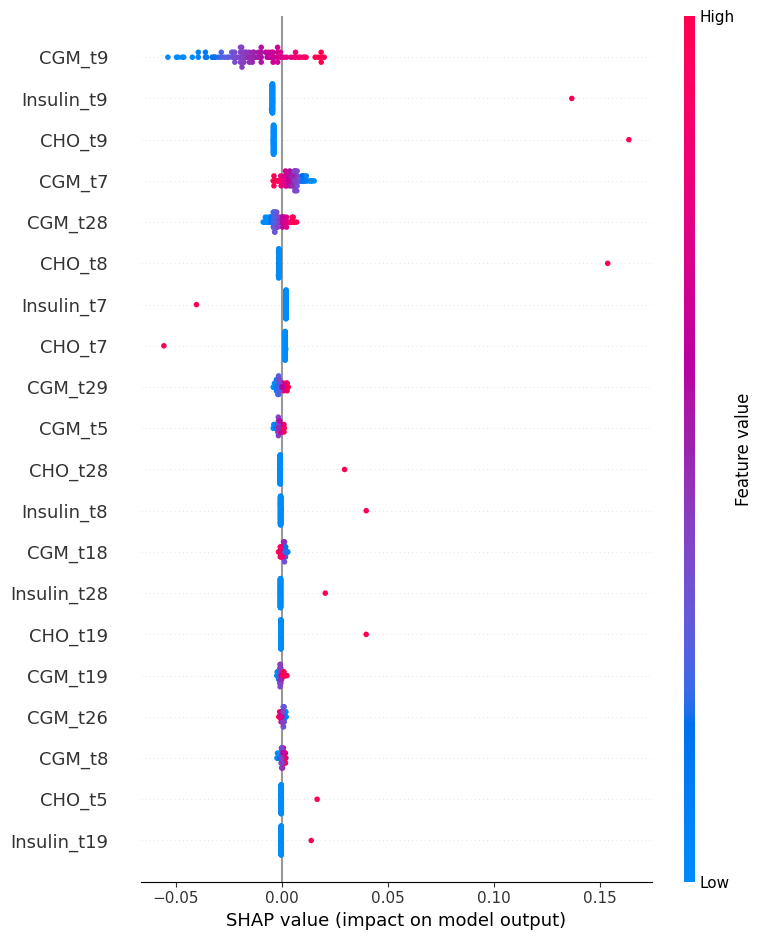

In [12]:
# Concatenate the test set inputs for SHAP analysis (KernelExplainer expects a single input)
X_test_combined = np.concatenate([X_cgm_test, X_insulin_test, X_cho_test], axis=2).reshape(X_cgm_test.shape[0], -1)

# Define a prediction function that takes a concatenated input and returns model predictions
def model_predict(X):
    # X is a single input with all features concatenated
    # Split it back into the respective feature sets expected by the model
    num_timesteps = X_cgm_test.shape[1]
    
    X_cgm_part = X[:, :num_timesteps].reshape(-1, num_timesteps, 1)
    X_insulin_part = X[:, num_timesteps:2*num_timesteps].reshape(-1, num_timesteps, 1)
    X_cho_part = X[:, 2*num_timesteps:].reshape(-1, num_timesteps, 1)
    
    return model.predict([X_cgm_part, X_insulin_part, X_cho_part])

# Use a subset of the training data as your background dataset
X_train_combined = np.concatenate([X_cgm_train, X_insulin_train, X_cho_train], axis=2).reshape(X_cgm_train.shape[0], -1)
background = X_train_combined[np.random.choice(X_train_combined.shape[0], 100, replace=False)]  # Select 100 samples

# Initialize the KernelExplainer
explainer = shap.KernelExplainer(model_predict, background)

# Compute SHAP values for the first 100 samples from the test set (this can be slow)
shap_values = explainer.shap_values(X_test_combined[:100])

# Squeeze the SHAP values to remove the extra dimension (remove singleton dimension)
shap_values = np.squeeze(shap_values)

# Print the shapes to debug any potential mismatch
print(f'SHAP values shape after squeezing: {shap_values.shape}')
print(f'X_test_combined shape: {X_test_combined[:100].shape}')

# Generate feature names for each timestep and feature
num_timesteps = X_cgm_test.shape[1]
feature_names = []
for t in range(num_timesteps):
    feature_names.extend([f"CGM_t{t}", f"Insulin_t{t}", f"CHO_t{t}"])

# Plot the summary plot for all features, ensuring that shapes match
shap.summary_plot(shap_values, X_test_combined[:100], feature_names=feature_names)

### Conglomerate the features to get an overall view

SHAP values combined shape: (100, 3)
Feature values combined shape: (100, 3)


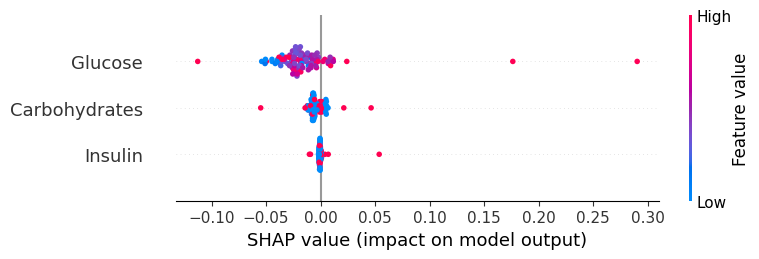

In [15]:
X_test_combined = np.concatenate([X_cgm_test[:100], X_insulin_test[:100], X_cho_test[:100]], axis=2).reshape(100, -1)

# Aggregating SHAP values across timesteps (for the first 100 samples)
shap_values_glucose = np.sum(shap_values[:, 0:num_timesteps], axis=1)
shap_values_insulin = np.sum(shap_values[:, num_timesteps:2*num_timesteps], axis=1)
shap_values_cho = np.sum(shap_values[:, 2*num_timesteps:], axis=1)

shap_values_combined = np.column_stack([shap_values_glucose, shap_values_insulin, shap_values_cho])

# Aggregating feature values across timesteps (e.g., mean or sum) for the same 100 samples
feature_values_glucose = np.mean(X_cgm_test[:100], axis=1)  # Mean glucose across all timesteps for the first 100 samples
feature_values_insulin = np.mean(X_insulin_test[:100], axis=1)  # Mean insulin across all timesteps for the first 100 samples
feature_values_cho = np.mean(X_cho_test[:100], axis=1)  # Mean CHO across all timesteps for the first 100 samples

# Combine the aggregated feature values into a single array
feature_values_combined = np.column_stack([feature_values_glucose, feature_values_insulin, feature_values_cho])

# Check shapes again to ensure they match
print(f'SHAP values combined shape: {shap_values_combined.shape}')
print(f'Feature values combined shape: {feature_values_combined.shape}')

# Define the new feature names for the combined SHAP values
combined_feature_names = ["Glucose", "Insulin", "Carbohydrates"]

# Plot the summary plot for the combined SHAP values with aggregated feature values
shap.summary_plot(shap_values_combined, feature_values_combined, feature_names=combined_feature_names)

### Display SHAP force plot

In [16]:
shap.initjs()

# Select a specific sample to plot (e.g., the first sample)
sample_index = 0
shap_values_for_sample = shap_values_combined[sample_index]
feature_values_for_sample = feature_values_combined[sample_index]

# Plot a force plot for the selected sample
shap.force_plot(
    base_value=explainer.expected_value,  # Use the expected value from your explainer
    shap_values=shap_values_for_sample,  # SHAP values for this sample
    features=feature_values_for_sample,  # Corresponding feature values for this sample
    feature_names=combined_feature_names  # Names of the features (Glucose, Insulin, Carbohydrates)
)

In [17]:
# Combine the datasets along the feature axis (axis=1)
X_test_combined = np.concatenate([X_cgm_test, X_cho_test, X_insulin_test], axis=1)
X_test_combined = X_test_combined.reshape(814, 90)

# Check the shape of the combined dataset
print("Shape of combined test dataset:", X_test_combined.shape)

Shape of combined test dataset: (814, 90)


### Display SHAP waterfall plot

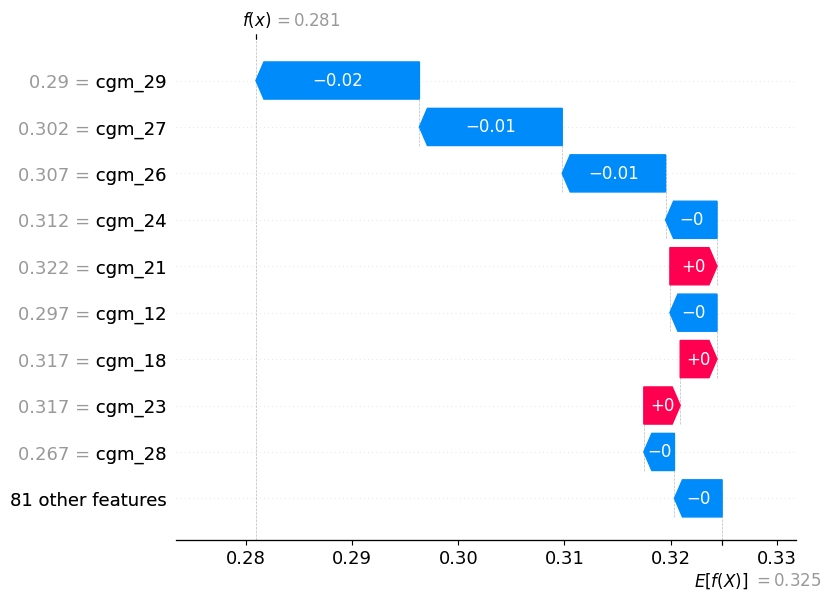

In [22]:
import xgboost as xgb
import shap

# Reshape if necessary to remove any extra dimensions
X_cgm_train = X_cgm_train.reshape(X_cgm_train.shape[0], -1)
X_insulin_train = X_insulin_train.reshape(X_insulin_train.shape[0], -1)
X_cho_train = X_cho_train.reshape(X_cho_train.shape[0], -1)

# Combine the datasets along the feature axis (axis=1)
X_train_combined = np.concatenate([X_cgm_train, X_insulin_train, X_cho_train], axis=1)

# Create feature names based on the original datasets
feature_names = (
    [f"cgm_{i}" for i in range(X_cgm_train.shape[1])] +
    [f"insulin_{i}" for i in range(X_insulin_train.shape[1])] +
    [f"cho_{i}" for i in range(X_cho_train.shape[1])]
)

# Convert the combined **train** dataset to a DataFrame with feature names
X_train_combined_df = pd.DataFrame(X_train_combined, columns=feature_names)

# For regression tasks, use XGBRegressor
model = xgb.XGBRegressor()

# Train the model with the combined training dataset
model.fit(X_train_combined_df, y_train)

# Combine test datasets (assuming you have X_cgm_test, X_insulin_test, X_cho_test)
X_cgm_test = X_cgm_test.reshape(X_cgm_test.shape[0], -1)
X_insulin_test = X_insulin_test.reshape(X_insulin_test.shape[0], -1)
X_cho_test = X_cho_test.reshape(X_cho_test.shape[0], -1)

X_test_combined = np.concatenate([X_cgm_test, X_insulin_test, X_cho_test], axis=1)

# Convert the combined test dataset to a DataFrame with feature names
X_test_combined_df = pd.DataFrame(X_test_combined, columns=feature_names)

# Create SHAP explainer (it will automatically use the column names as feature names)
explainer = shap.Explainer(model, X_train_combined_df)

# Calculate SHAP values for the combined test set
shap_values = explainer(X_test_combined_df)

# Plot the SHAP values for the first instance
shap.waterfall_plot(shap_values[0])